In [75]:
import nlp_utils
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import LdaModel
import gensim
import numpy as np

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Load parsed news dataset
dataset = nlp_utils.NewsTextDataset()
dataset.load("datasets/final_dataset_4k.json")

In [4]:
# Preprocessing
dataset.preprocess()

3999it [00:45, 88.18it/s] 


In [70]:
data = dataset.dump_to_pandas()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
data.head()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,category,tokenized_text
0,экономика,"[сооснователь, прошлый, многолетний, руководит..."
1,экономика,"[минэкономразвития, дорабатывать, вносить, пра..."
2,экономика,"[счет, который, открывать, российский, граждан..."
3,экономика,"[российский, рубль, являться, самый, недооцени..."
4,экономика,"[российский, онлайн, кинотеатр, откладывать, н..."


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


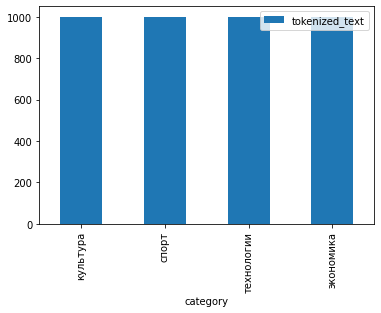

In [72]:
import matplotlib.pyplot as plt
data.groupby('category').count().plot.bar(ylim=0)
plt.show()

In [8]:
# useless maybe
def convert_list_to_string(org_list, seperator=' '):
    return seperator.join(org_list)

In [9]:
# useless maybe
 = data['tokenized_text'].apply(convert_list_to_string)

In [10]:
data.head()

,category,tokenized_text
0,экономика,сооснователь прошлый многолетний руководитель ...
1,экономика,минэкономразвития дорабатывать вносить правите...
2,экономика,счет который открывать российский гражданин ко...
3,экономика,российский рубль являться самый недооценивать ...
4,экономика,российский онлайн кинотеатр откладывать неопре...


In [14]:
# useless maybe
vectorizer = TfidfVectorizer(min_df= 3, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(data['tokenized_text'])

In [64]:
from gensim.corpora import Dictionary
def prep_corpus(docs, no_below=3, no_above=0.5):
    dictionary = Dictionary(docs)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('Creating corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus


/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:

dictionary, corpus = prep_corpus(data['tokenized_text'])

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
Building dictionary...
INFO:gensim.corpora.dictionary:built Dictionary(39136 unique tokens: ['азия', 'американский', 'арканзас', 'бедный', 'безопасный']...) from 3999 documents (total 942494 corpus positions)
INFO:gensim.corpora.dictionary:discarding 22806 tokens: [('высокопродуктивный', 1), ('год', 3182), ('землевладелец', 1), ('земледелие', 1), ('игнорироваться', 1), ('который', 3260), ('луизиана', 1), ('мелинда', 2), ('небраска', 2), ('сахара', 2)]...
INFO:gensim.corpora.dictionary:keeping 16330 tokens which

In [152]:
# Trying to add GridSearch
from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import LdaTransformer
from sklearn.model_selection import GridSearchCV
param_grid = {'num_topics': [4, 8, 16, 32],
               'passes': [10, 50, 100],
               'iterations':[50, 100, 500],
               'decay': [0.5, 0.75, 0.9]
               }
# Reduce each document to 2 dimensions (topics) using the sklearn interface.
model = LdaTransformer(id2word=dictionary)
sh = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=10).fit(corpus)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [76]:
# Train the model on the corpus.
lda = LdaModel(corpus, 
               id2word=dictionary,num_topics=4,
               passes=50,
               iterations=500,
               random_state=np.random.RandomState(42))

"
INFO:gensim.models.ldamodel:topic #3 (0.250): 0.009*"", " + 0.008*"фильм" + 0.004*"человек" + 0.004*"весь" + 0.004*"россия" + 0.004*"хороший" + 0.004*"режиссер" + 0.004*"сообщать" + 0.004*"", "" + 0.003*"получать"
INFO:gensim.models.ldamodel:topic diff=0.076369, rho=0.150757
INFO:gensim.models.ldamodel:-7.893 per-word bound, 237.7 perplexity estimate based on a held-out corpus of 1999 documents with 337772 words
INFO:gensim.models.ldamodel:PROGRESS: pass 41, at document #3999/3999
INFO:gensim.models.ldamodel:merging changes from 1999 documents into a model of 3999 documents
INFO:gensim.models.ldamodel:topic #0 (0.250): 0.019*"компания" + 0.007*"данные" + 0.006*"сервис" + 0.006*"мочь" + 0.006*"система" + 0.006*"пользователь" + 0.005*"приложение" + 0.005*"новый" + 0.004*"получать" + 0.004*"банк"
INFO:gensim.models.ldamodel:topic #1 (0.250): 0.008*"рубль" + 0.008*"россия" + 0.006*"российский" + 0.006*"нефть" + 0.006*"доллар" + 0.006*"млрд" + 0.005*"страна" + 0.005*"компания" + 0.005*"мл

In [78]:

import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [79]:
pyLDAvis.display(vis_data)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_v')

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:1 batches submitted to accumulate stats from 64 documents (9570 virtual)
INFO:gensim.topic_coherence.text_analysis:2 batches submitted to accumulate stats from 128 documents (19239 virtual)
INFO:gensim.topic_coherence.text_analysis:3 batches submitted to accumulate stats from 192 documents (29749 virtual)
INFO:gensim.topic_coherence.text_analysis:4 batches submitted to accumulate stats fro

In [122]:
import gensim.downloader as api

w2v_model = api.load("word2vec-ruscorpora-300")

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.utils_any2vec:loading projection weights from /home/alexander/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz
INFO:gensim.models.utils_any2vec:loaded (184973, 300) matrix from /home/alexander/gensim-data/word2vec-ruscorpora-300/word2vec-ruscorpora-300.gz


In [123]:
cleaned_w2v_dict = {k.split('_')[0]: v for k, v in w2v_model.vocab.items()}
w2v_model.vocab = cleaned_w2v_dict

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
coherence_model_lda_w2v = CoherenceModel(model=lda, texts=data['tokenized_text'], dictionary=dictionary, coherence='c_w2v',keyed_vectors=w2v_model)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
coherence_lda = coherence_model_lda_w2v.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

Coherence Score:  0.53176177


In [134]:
w2v_model.most_similar('экономика', topn=10)

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('экономический_ADJ', 0.7668749094009399), ('макроэкономический_ADJ', 0.6986626386642456), ('социально-экономический_ADJ', 0.6937588453292847), ('инвестиция_NOUN', 0.683314323425293), ('сырьевой_ADJ', 0.6750128865242004), ('отрасль_NOUN', 0.6717628240585327), ('многоукладный_ADJ', 0.6702179908752441), ('посткризисный_ADJ', 0.6684015989303589), ('конкурентоспособность_NOUN', 0.66672682762146), ('агропродовольственный_ADJ', 0.658062756061554)]

In [136]:
topics = lda.print_topics()

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:gensim.models.ldamodel:topic #0 (0.250): 0.019*"компания" + 0.007*"данные" + 0.006*"сервис" + 0.006*"мочь" + 0.006*"система" + 0.006*"пользователь" + 0.005*"приложение" + 0.005*"новый" + 0.004*"получать" + 0.004*"банк"
INFO:gensim.models.ldamodel:topic #1 (0.250): 0.008*"рубль" + 0.008*"россия" + 0.006*"российский" + 0.006*"нефть" + 0.006*"доллар" + 0.006*"млрд" + 0.005*"страна" + 0.005*"компания" + 0.005*"млн" + 0.005*"мочь"
INFO:gensim.models.ldamodel:topic #2 (0.250): 0.010*"матч" + 0.008*"команда" + 0.007*".." + 0.007*"первый" + 0.006*"чемпионат" + 0.005*"сборная" + 0.005*"клуб" + 0.00

In [138]:
topics[0]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.019*"компания" + 0.007*"данные" + 0.006*"сервис" + 0.006*"мочь" + 0.006*"система" + 0.006*"пользователь" + 0.005*"приложение" + 0.005*"новый" + 0.004*"получать" + 0.004*"банк"')

In [139]:
topics[1]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1, '0.008*"рубль" + 0.008*"россия" + 0.006*"российский" + 0.006*"нефть" + 0.006*"доллар" + 0.006*"млрд" + 0.005*"страна" + 0.005*"компания" + 0.005*"млн" + 0.005*"мочь"')

In [140]:
topics[2]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2, '0.010*"матч" + 0.008*"команда" + 0.007*".." + 0.007*"первый" + 0.006*"чемпионат" + 0.005*"сборная" + 0.005*"клуб" + 0.005*"россия" + 0.005*"место" + 0.004*"второй"')

In [141]:
topics[3]

/home/alexander/HSE_Stuff/Topic_modeling/topic_modeling/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3, '0.009*"", " + 0.008*"фильм" + 0.004*"человек" + 0.004*"весь" + 0.004*"россия" + 0.004*"хороший" + 0.004*"сообщать" + 0.004*"режиссер" + 0.004*"", "" + 0.003*"получать"')